<a href="https://colab.research.google.com/github/VisarBuza/artificial-intelligence-2021-22/blob/main/assignment-three/classification/StrokePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction Dataset

In this notebook we present and preprocesss the dataset for stroke that consists of 11 clinical features that help predict stroke events. The dataset can be found [here](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset).

##AIM - Given set of features for a patient, predict chances of stroke.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

##Exploring the dataset

In [ ]:
df = pd.read_csv('/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df['bmi'].isnull().value_counts()

False    4909
True      201
Name: bmi, dtype: int64

BMI has 4% missing values

**1. Check for Numerical and categorical features**

In [ ]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

s = (df.dtypes != 'object')
num_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

print("Numerical variables:")
print(num_cols)

Categorical variables:
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical variables:
['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


Obervation:

We have both numerical type as well as categorical type variables. Since model takes numbers as input, we will have to encode the categorical features later on in thr pre-processing step before feeding it to the model.

**b. Bivariate Analysis of numerical features**

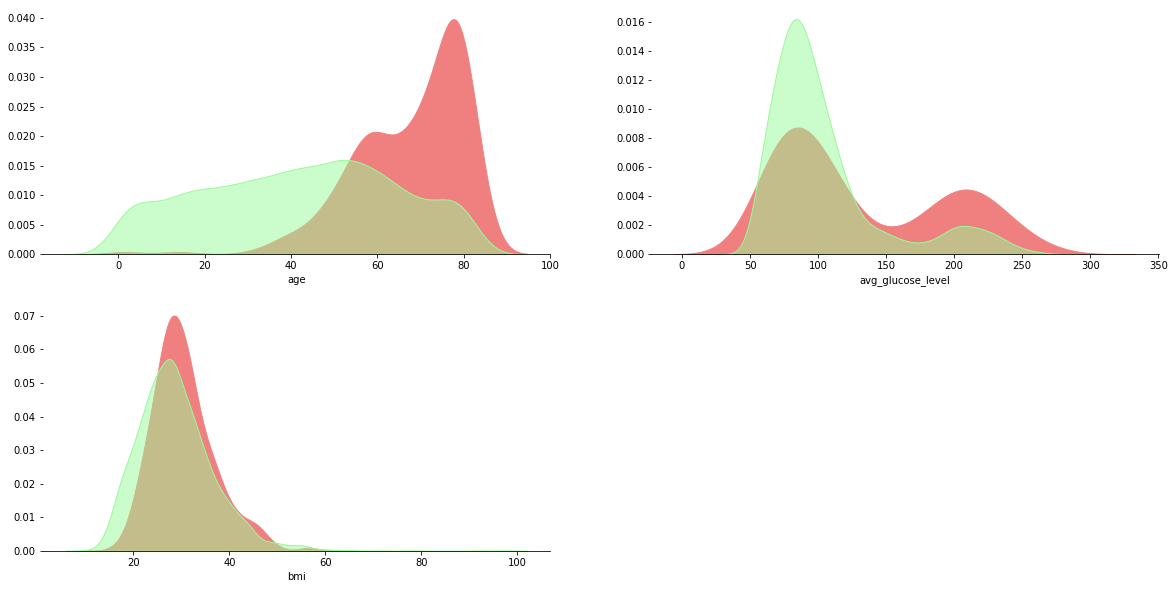

In [ ]:
fig=plt.figure(figsize=(20,10),facecolor='white')
gs=fig.add_gridspec(2,2)
ax=[None for i in range(3)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,0])


sns.kdeplot(data=df[df.stroke==1],x='age',ax=ax[0],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=df[df.stroke==0],x='age',ax=ax[0],shade=True,color='palegreen',alpha=0.5)

sns.kdeplot(data=df[df.stroke==1],x='avg_glucose_level',ax=ax[1],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=df[df.stroke==0],x='avg_glucose_level',ax=ax[1],shade=True,color='palegreen',alpha=0.5)

sns.kdeplot(data=df[df.stroke==1],x='bmi',ax=ax[2],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=df[df.stroke==0],x='bmi',ax=ax[2],shade=True,color='palegreen',alpha=0.5)

for i in range(3):
    ax[i].set_ylabel('')
    #ax[i].grid(which='both', axis='y', zorder=0, color='black', linestyle=':', dashes=(2,7))
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)

Observations:

People with age 65-85 have high chances of getting stroke.
bmi can't distinguish stroke patterns and also have 4% missing values, hence I will drop this feature.

In [ ]:
df = df.drop('bmi', axis=1)

**2. Checking the distribution of Categorical variables**

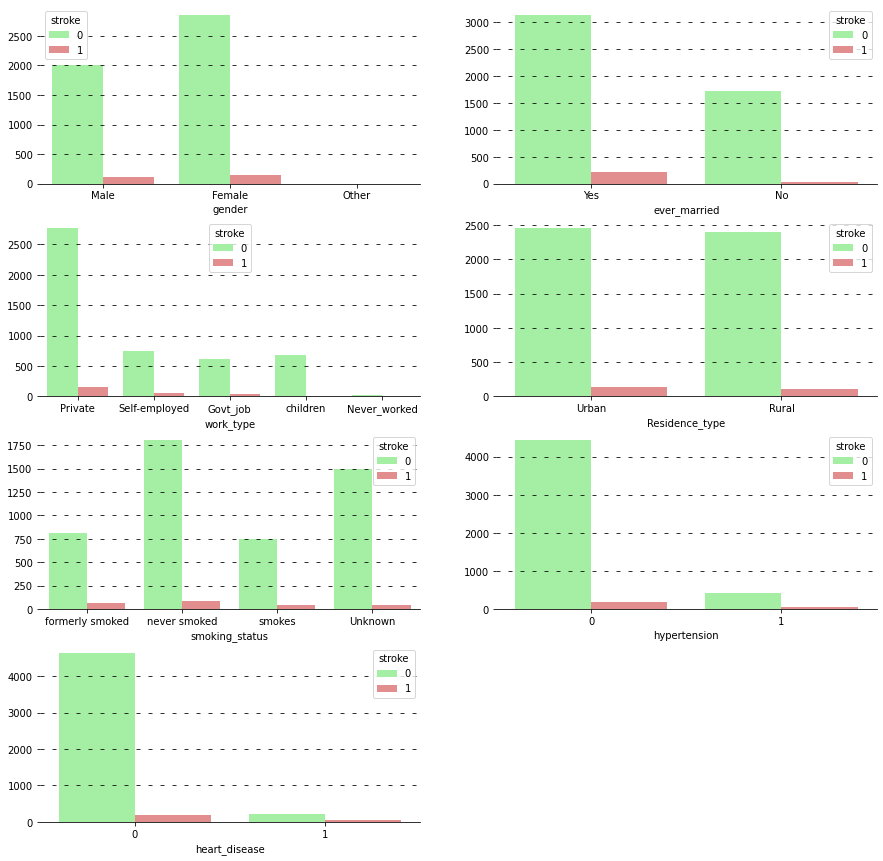

In [ ]:
palettes = ['palegreen','lightcoral']
fig=plt.figure(figsize=(15,15),facecolor='white')

gs=fig.add_gridspec(4,2)

object_cols.append('hypertension')
object_cols.append('heart_disease')

ax=[None for _ in range(len(object_cols))]

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,0])
ax[3]=fig.add_subplot(gs[1,1])
ax[4]=fig.add_subplot(gs[2,0])
ax[5]=fig.add_subplot(gs[2,1])
ax[6]=fig.add_subplot(gs[3,0])

#palette1=["wheat" for _ in range(10)]
#palette1[0] = "gold"

sns.countplot(data=df, hue='stroke', ax=ax[0],x=object_cols[0], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[1],x=object_cols[1], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[2],x=object_cols[2], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[3],x=object_cols[3], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[4],x=object_cols[4], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[5],x=object_cols[5], palette=palettes, orient='v')
sns.countplot(data=df, hue='stroke', ax=ax[6],x=object_cols[6], palette=palettes, orient='v')

for i in range(7):
    ax[i].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(5,10))
    ax[i].set_ylabel('')
    ax[i].set_xlabel(object_cols[i])
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)


#plt.tight_layout()

Observation:

We see that in every feature, there are higher samples of no stroke (stroke=0) as compared to the other class. Hence it is a Highly Imbalanced dataset
Others category in 'gender' can be ignored

In [ ]:
df = df[df['gender'] != 'Other']

**3. Some pairwise Analysis**

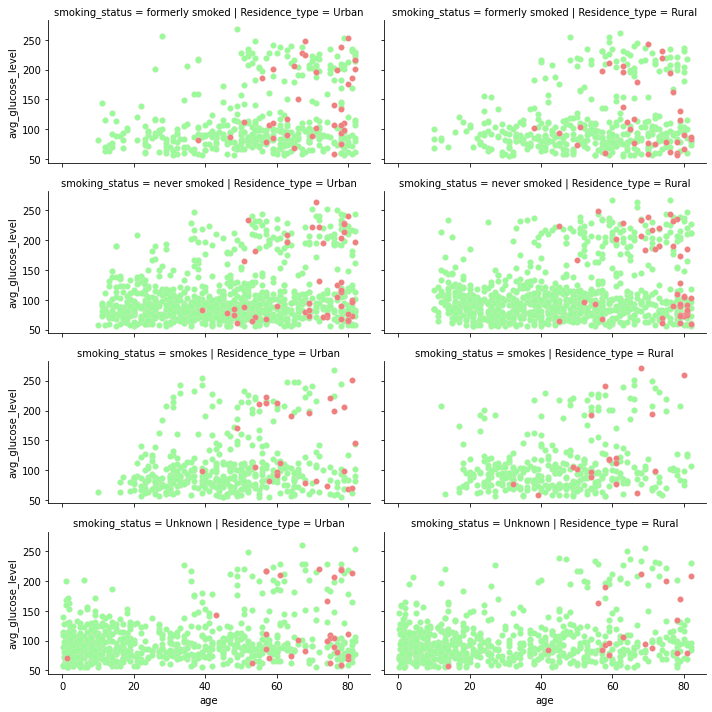

In [ ]:
g = sns.FacetGrid(data=df, row='smoking_status', col='Residence_type', hue='stroke',
                  size=2.5, aspect=2, palette=palettes)
g.map(plt.scatter, 'age', 'avg_glucose_level', edgecolor='#EAE0D5', lw=0.2)

Observation:

Type of Residence either Urban or Rural has no effect on having stroke. This feature can also be dropped.

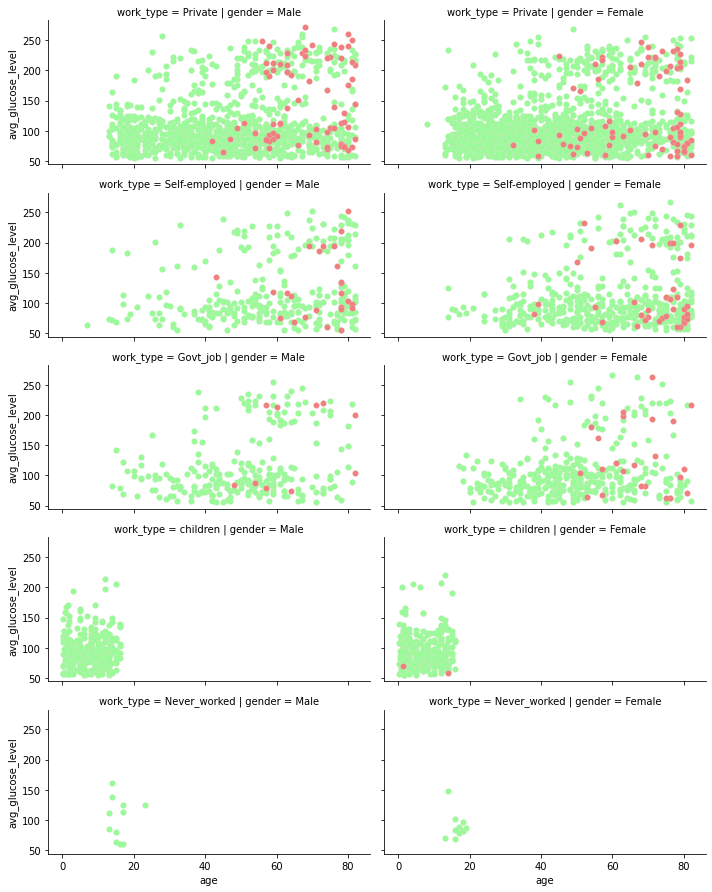

In [ ]:
g = sns.FacetGrid(data=df, row='work_type', col='gender', hue='stroke',
                  size=2.5, aspect=2, palette=palettes)
g.map(plt.scatter, 'age', 'avg_glucose_level', edgecolor='#EAE0D5', lw=0.2)

Interesting Observations:

Only 2 children have strokes and both are female
Older females in govt_jobs have higher risk of stroke.

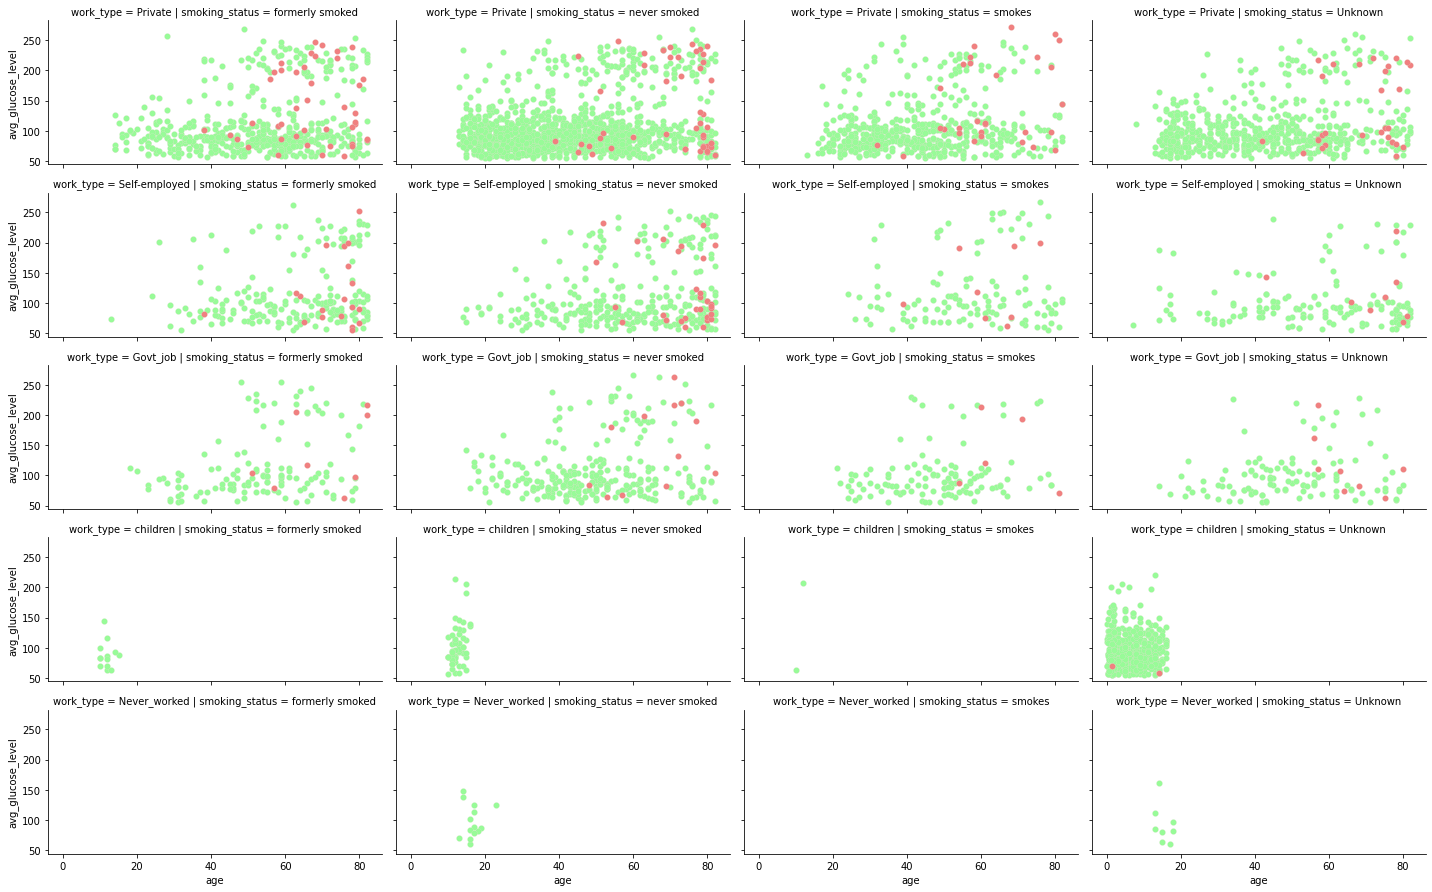

In [ ]:
g = sns.FacetGrid(data=df, row='work_type', col='smoking_status', hue='stroke',
                  size=2.5, aspect=2, palette=palettes)
g.map(plt.scatter, 'age', 'avg_glucose_level', edgecolor='#EAE0D5', lw=0.2)

Observation:

Majority of people who had stroke were working in 'Private' sector

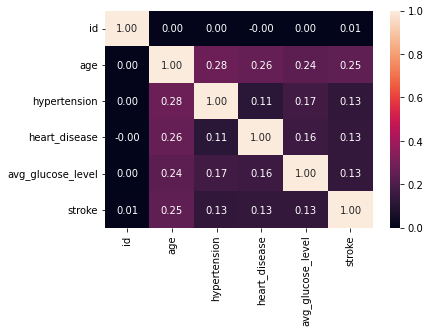

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.2f')

# Data Preprocessing

**1. Encoding categorical variables**

In [14]:
obj_feat = df.dtypes[df.dtypes == 'O'].index.values
le = LabelEncoder()

for i in obj_feat:
    df[i] = le.fit_transform(df[i])
df


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,2,1,83.75,2,0
5106,44873,0,81.0,0,0,1,3,1,125.20,2,0
5107,19723,0,35.0,0,0,1,3,0,82.99,2,0
5108,37544,1,51.0,0,0,1,2,0,166.29,1,0


**2. Standardizing and splitting**

In [15]:
X = df.drop('stroke', axis=1)
y = df['stroke']

scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [16]:
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((4087, 10), (1022, 10), (4087,), (1022,))

In [17]:
#testing = X_test['id']

X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

X_train.shape, X_test.shape

((4087, 9), (1022, 9))

#Training multiple models without correcting data imbalance issue

In [18]:
all_model = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
            RandomForestClassifier(), BernoulliNB(), SVC()]

recall = []
precision = []
f1=[]
for model in all_model:
    cv = cross_val_score(model, X_train, y_train, scoring='recall', cv=10).mean()
    recall.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='precision', cv=10).mean()
    precision.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='f1', cv=10).mean()
    f1.append(cv)

model = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
         'RandomForestClassifier', 'BernoulliNB', 'SVC']

score = pd.DataFrame({'Model': model, 'Precision': precision, 'Recall': recall, 'F1':f1})
score.style.background_gradient(high=1,axis=0)

,Model,Precision,Recall,F1
0,LogisticRegression,0.000000,0.000000,0.000000
1,KNeighborsClassifier,0.100000,0.010526,0.019048
2,DecisionTreeClassifier,0.113527,0.155526,0.146700
3,RandomForestClassifier,0.100000,0.010526,0.019524
4,BernoulliNB,0.101905,0.030526,0.046866
5,SVC,0.000000,0.000000,0.000000


We can see how poor the model performs without training it with enough samples from both classes.

#Imbalanced data handling - SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_bal, Y_bal = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=11)

In [20]:
testing = X_test['id']

X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

X_train.shape, X_test.shape

((7776, 9), (1944, 9))

In [21]:
all_model = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(),
            RandomForestClassifier(), BernoulliNB(), SVC()]

recall = []
precision = []
f1=[]
balanced_accuracy=[]


for model in all_model:
    cv = cross_val_score(model, X_train, y_train, scoring='recall', cv=10).mean()
    recall.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='precision', cv=10).mean()
    precision.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='f1', cv=10).mean()
    f1.append(cv)
    
    cv = cross_val_score(model, X_train, y_train, scoring='balanced_accuracy', cv=10).mean()
    balanced_accuracy.append(cv)

model = ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier',
         'RandomForestClassifier', 'BernoulliNB', 'SVC']

score = pd.DataFrame({'Model': model, 'Precision': precision, 'Recall': recall, 'F1':f1, 'balanced_accuracy':balanced_accuracy})
score.style.background_gradient(high=1,axis=0)

,Model,Precision,Recall,F1,balanced_accuracy
0,LogisticRegression,0.763862,0.829994,0.795467,0.789263
1,KNeighborsClassifier,0.844827,0.963350,0.900185,0.895011
2,DecisionTreeClassifier,0.903553,0.911876,0.908050,0.906150
3,RandomForestClassifier,0.948327,0.948791,0.947980,0.946126
4,BernoulliNB,0.661136,0.929817,0.772702,0.731385
5,SVC,0.787636,0.891602,0.836376,0.828087


**We can see the difference in learning with proper training. Random Forest outperform with clear win! Let's train RF model and evaluate it's performance on test data**

In [22]:
model_1 = RandomForestClassifier(random_state=1)

# Train the model (will take about 10 minutes to run)
model_1.fit(X_train, y_train)
pred = model_1.predict(X_test)

#print(confusion_matrix(y_test, pred, labels=(1,0)))
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       931
           1       0.96      0.95      0.95      1013

    accuracy                           0.95      1944
   macro avg       0.95      0.95      0.95      1944
weighted avg       0.95      0.95      0.95      1944



Okay! So it's F1-score is 0.95 on test set. Let's try to improve it with boosting models.

**Trying Boosting Ensemble method**

In [23]:
from xgboost import XGBClassifier
model_2 = XGBClassifier(n_estimators=1000,learning_rate=0.05) # Your code here

# Fit the model
model_2.fit(X_train, y_train, 
             early_stopping_rounds=20, 
             eval_set=[(X_test, y_test)], 
             verbose=False) # Your code here

# Get predictions
predictions_2 = model_2.predict(X_test) # Your code here

print(classification_report(y_test, predictions_2))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       931
           1       0.94      0.90      0.92      1013

    accuracy                           0.92      1944
   macro avg       0.92      0.92      0.92      1944
weighted avg       0.92      0.92      0.92      1944



Performance improved by XGBoost!!!

In [24]:
from lightgbm import LGBMClassifier

lgbm_parameters = {
    'metric': 'f1', 
    'n_jobs': -1,
    'n_estimators': 50000,
    'reg_alpha': 10.924491968127692,
    'reg_lambda': 17.396730654687218,
    'colsample_bytree': 0.21497646795452627,
    'subsample': 0.7582562557431147,
    'learning_rate': 0.009985133666265425,
    'max_depth': 20,
    'num_leaves': 65,
    'min_child_samples': 27,
    'max_bin': 523,
    'cat_l2': 0.025083670064082797
}

lgbm_model = LGBMClassifier(**lgbm_parameters)
# Fit the model
lgbm_model.fit(X_train, y_train, 
             eval_set=[(X_test, y_test)], 
             verbose=False) # Your code here

# Get predictions
predictions_3 = lgbm_model.predict(X_test) 

print(classification_report(y_test, predictions_3))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       931
           1       0.96      0.88      0.92      1013

    accuracy                           0.92      1944
   macro avg       0.92      0.92      0.92      1944
weighted avg       0.93      0.92      0.92      1944



Light GBM classifier didn't outperform XGBoost.

#Plotting Confusion Matrix of RF, XGB, LGBM


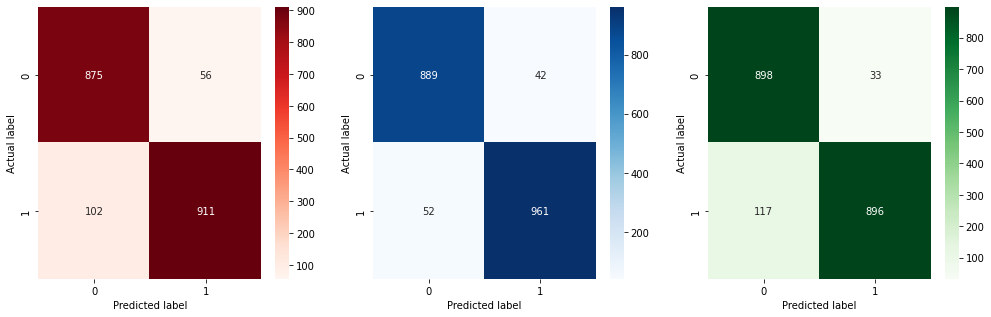

In [25]:
fig=plt.figure(figsize=(17,5),facecolor='white')
gs=fig.add_gridspec(1,3)
ax=[None for i in range(3)]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[0,2])

cm_XGBoost = confusion_matrix(y_test,predictions_2)
sns.heatmap(cm_XGBoost, annot=True, ax = ax[0], fmt = 'g' ,cmap=plt.cm.Reds)
cm_RF = confusion_matrix(y_test,pred)
sns.heatmap(cm_RF, annot=True, ax = ax[1], fmt = 'g' ,cmap=plt.cm.Blues)
cm_LGBM = confusion_matrix(y_test,predictions_3)
sns.heatmap(cm_LGBM, annot=True, ax = ax[2], fmt = 'g' ,cmap=plt.cm.Greens)
title=['XG_Boost','RF','LGBM']

for i in range(3):
    #ax[i].grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(5,10))
    ax[i].set_xlabel('Predicted label')
    ax[i].set_ylabel('Actual label')
    #ax[i].text(title[i])
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)

AUC score for RF and XGBoost 0.9881847475832438 0.976242785782677


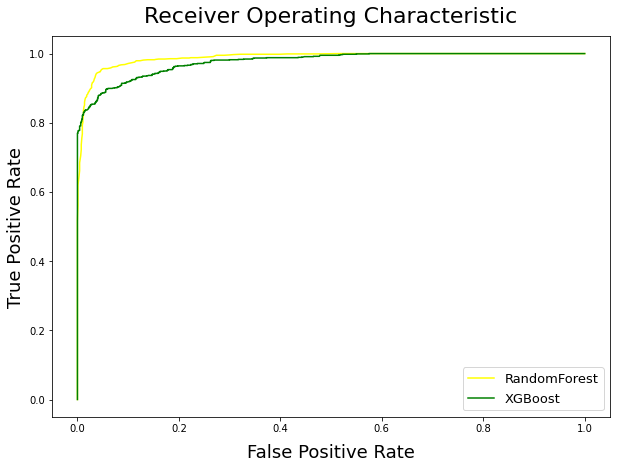

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

pred_prob1 = model_1.predict_proba(X_test)
pred_prob2 = model_2.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print('AUC score for RF and XGBoost',auc_score1, auc_score2)

plt.figure(figsize=(10,7)) #to set the size of the figure generated

plt.plot(fpr1, tpr1,color='yellow', label='RandomForest')
plt.plot(fpr2, tpr2,color='green', label='XGBoost')

plt.xlabel('False Positive Rate',fontsize=18,labelpad =10) #Label for x axis
plt.ylabel('True Positive Rate',fontsize=18) #Label for y axis

plt.title('Receiver Operating Characteristic',fontsize=22).set_position([.5, 1.02]) #Plot title
plt.legend(loc="lower right",fontsize=13)
plt.show()

In [27]:
print("Accuracy of final XGBoost model :",accuracy_score(y_test,predictions_2)*100)

Accuracy of final XGBoost model : 91.8724279835391


XGBoost performed best amongst all the baselines with 96.5% accuracy.